In [61]:
import torch
from dataset.ReadImages import readImageswithPattern
import random
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from utils import *
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
from model.siamese import TuneClassif
# model = torch.load('data/best_classif_1.ckpt')
# model = models.alexnet(pretrained=True)
model = TuneClassif(models.resnet152(pretrained=True), 2)
n_filters = 2048
model.cpu()

TuneClassif (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (4): Bottleneck (
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (downsample): Sequential (
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (5): Bott

In [92]:
dataset_path = '/home/mrim/kohlm/nnForRetrieval/data/pre_proc/fourviere_227sq'
dataset_test = '/home/mrim/kohlm/nnForRetrieval/data/pre_proc/fourviere_227sq/test'

In [93]:
def match(x):
    return x.split('/')[-1].split('-')[0]

trainSetFull = readImageswithPattern(dataset_path, match)
testSetFull = readImageswithPattern(dataset_test, match)

In [94]:
random.shuffle(trainSetFull)
random.shuffle(testSetFull)

In [95]:
inputs1 = torch.Tensor(10, 3, 227, 227)
inputs2 = torch.Tensor(10, 3, 227, 227)
trans = transforms.Compose([Image.open, transforms.ToTensor()])
for i, (im, lab) in enumerate(trainSetFull[:10]):
    inputs1[i] = trans(im)
    inputs1[i] = norm_image_t(inputs1[i])
for i, (im, lab) in enumerate(testSetFull[:10]):
    inputs2[i] = trans(im)
    inputs2[i] = norm_image_t(inputs1[i])

In [96]:
outputs1 = model.features(Variable(inputs1, volatile=True))
outputs2 = model.features(Variable(inputs2, volatile=True))

In [97]:
def scale_minmax(t):
    # scale tensor t to [0, 1]
    v1, v2 = t.min(), t.max()
    return (t - v1) / (v2 - v1)

def to_PIL(t):
    t = t.mul(255).byte().numpy()
    t = np.transpose(t, (1, 2, 0))
    t = t[:, :, 0]
    return Image.fromarray(t, mode='L')

trans_out = transforms.Compose([scale_minmax, to_PIL, np.asarray])
trans_in = transforms.Compose([Image.open, np.asarray])

def show_outputs(dataset, outputs):
    for (im_in, lab), out in zip(dataset, outputs.data):
        img_in = trans_in(im_in)
        max_i, max_f = max(enumerate(out), key=lambda x: x[1].norm(1))
        print('label:{0}, max filter: {1}'.format(lab, max_i))
        img = trans_out(max_f.view(1, out.size(1), out.size(2)))
        plt.figure()
        plt.imshow(img_in)
        plt.figure()
        plt.imshow(img)

label:B_060, max filter: 558
label:A_008, max filter: 1916
label:C_005, max filter: 1740
label:D_009, max filter: 656
label:A_031, max filter: 773
label:A_034, max filter: 536
label:B_032, max filter: 1404
label:C_052, max filter: 274
label:A_007, max filter: 1364
label:A_035, max filter: 1835


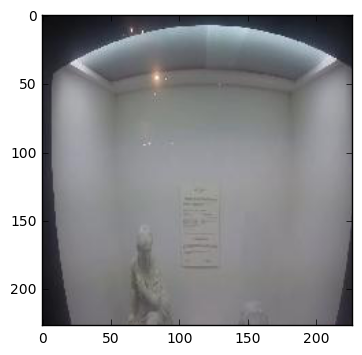

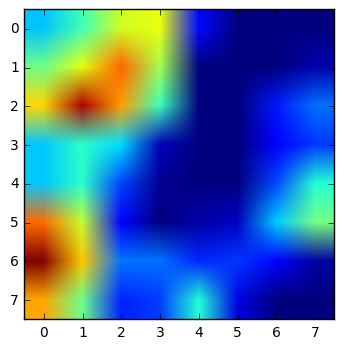

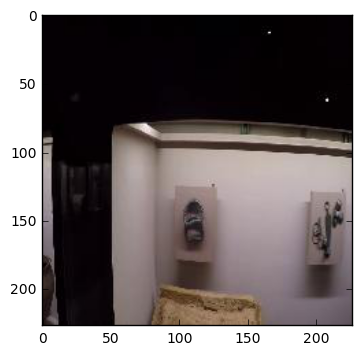

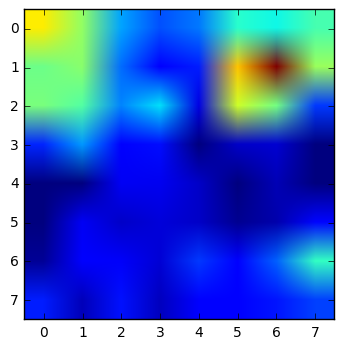

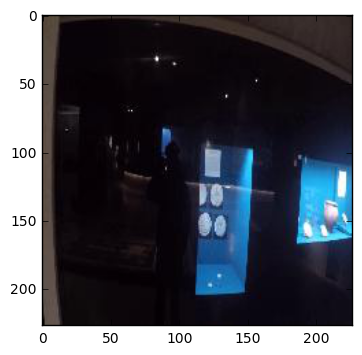

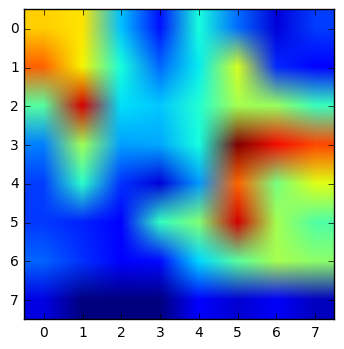

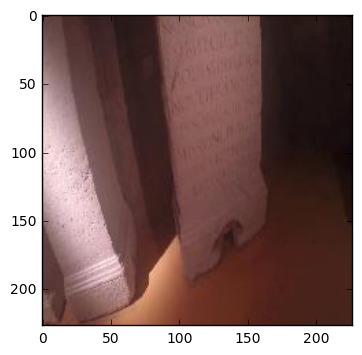

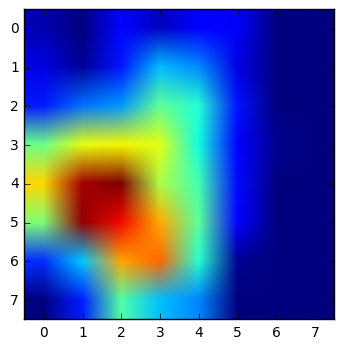

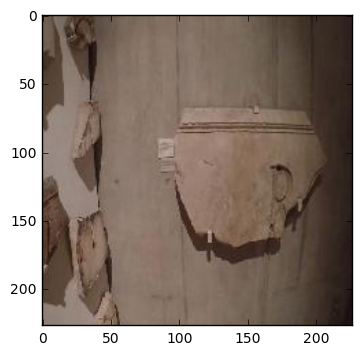

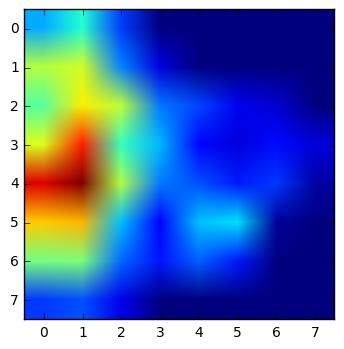

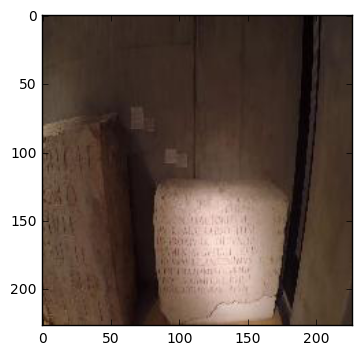

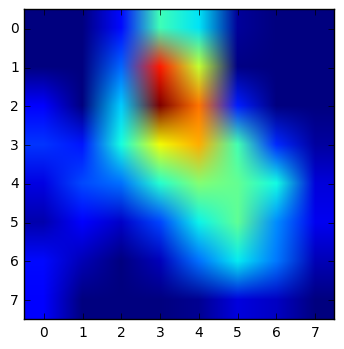

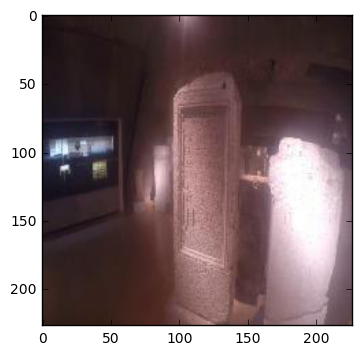

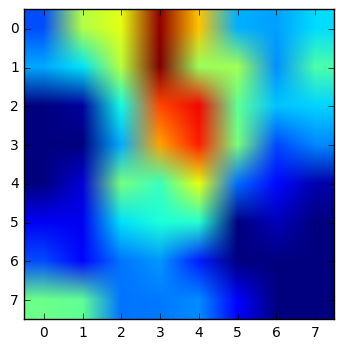

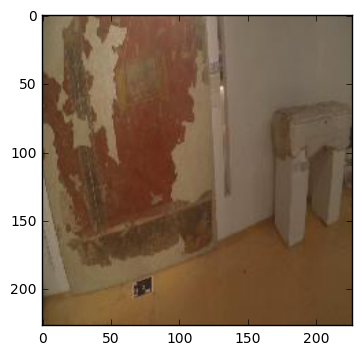

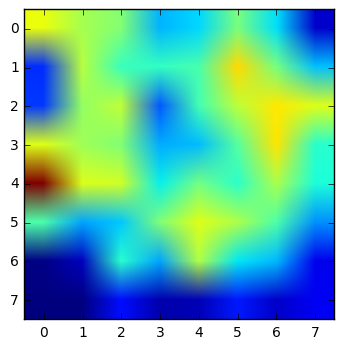

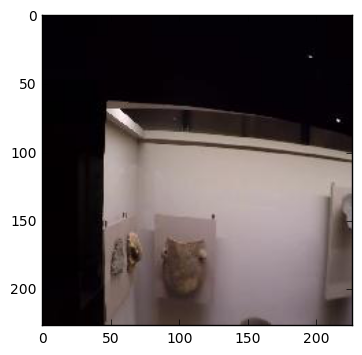

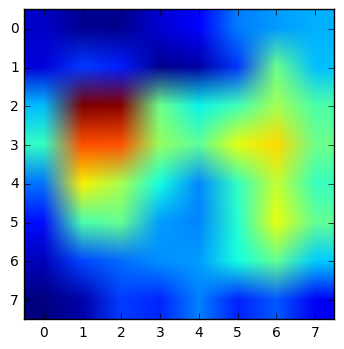

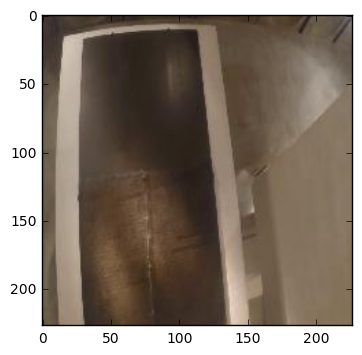

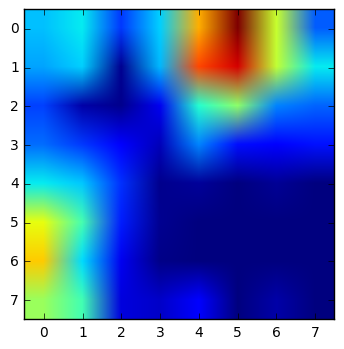

In [98]:
show_outputs(trainSetFull[:10], outputs1)

label:C_012, max filter: 558
label:B_078, max filter: 1916
label:B_063, max filter: 1740
label:A_025, max filter: 656
label:C_006, max filter: 773
label:A_011, max filter: 536
label:D_006, max filter: 1404
label:A_006, max filter: 274
label:A_058, max filter: 1364
label:C_010, max filter: 1835


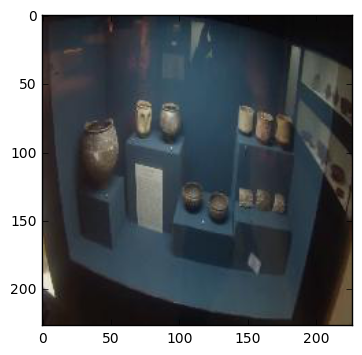

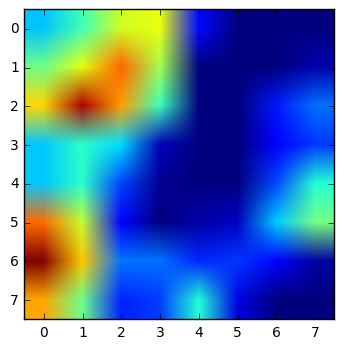

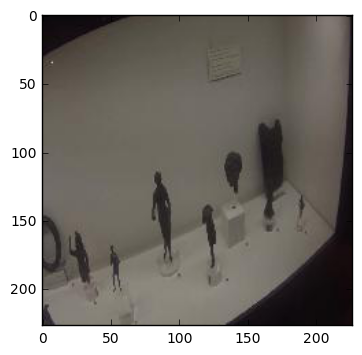

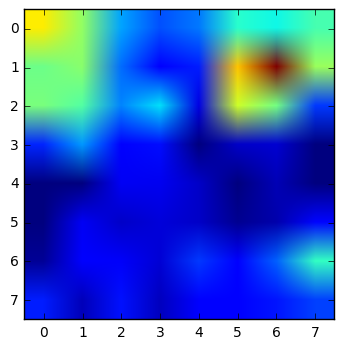

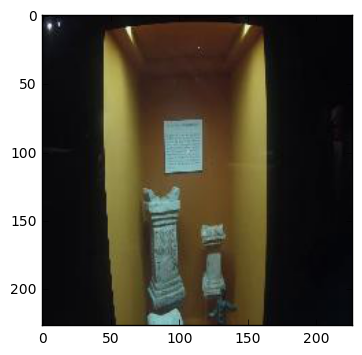

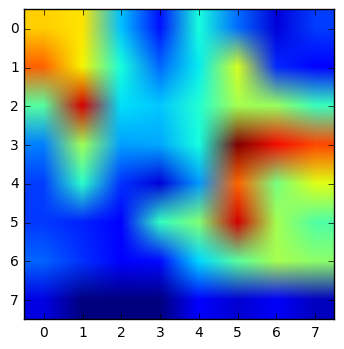

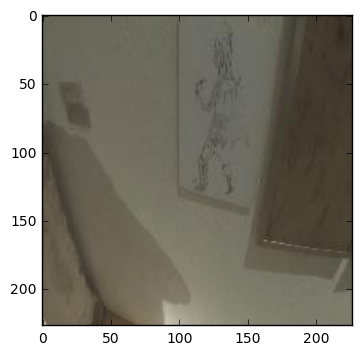

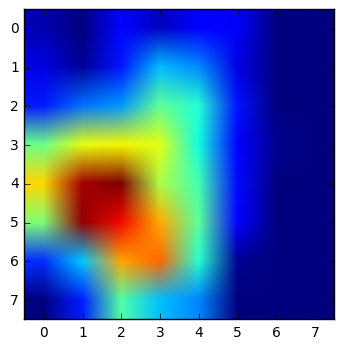

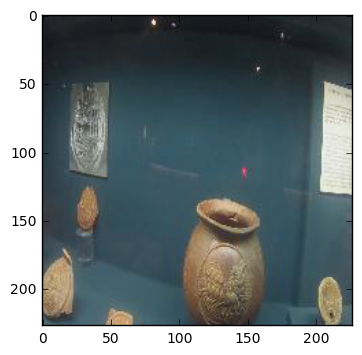

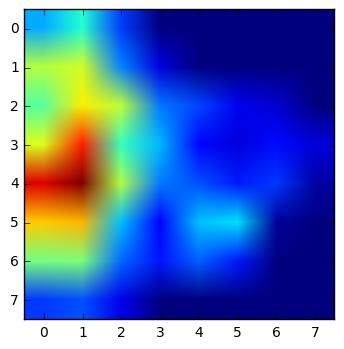

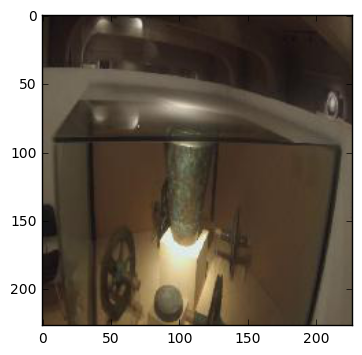

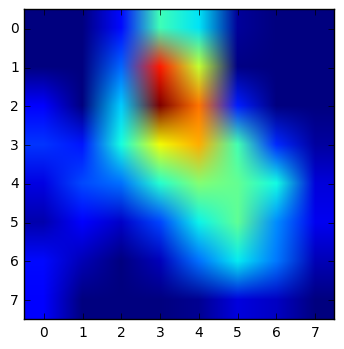

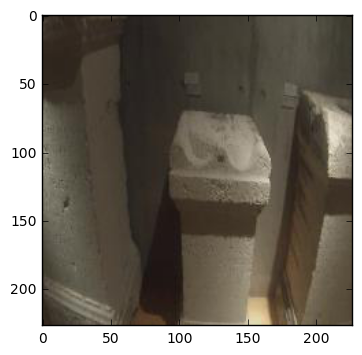

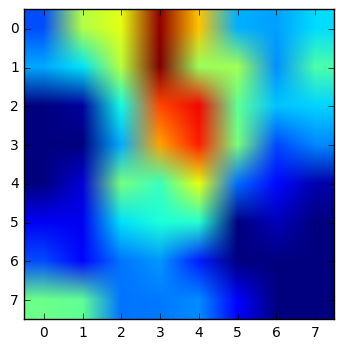

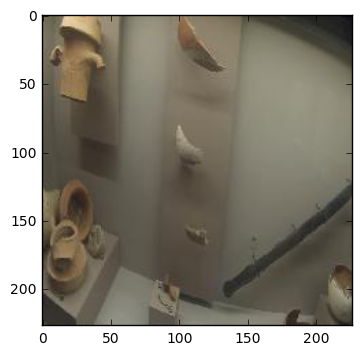

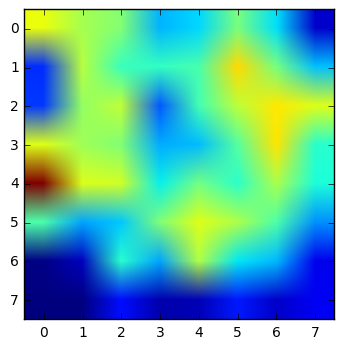

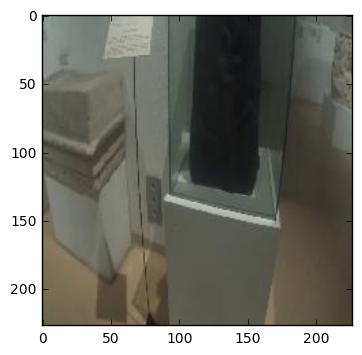

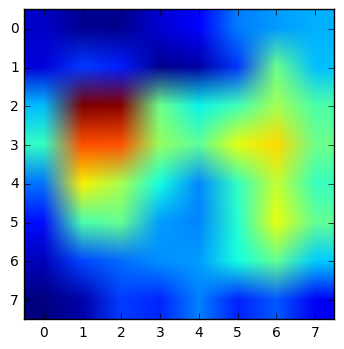

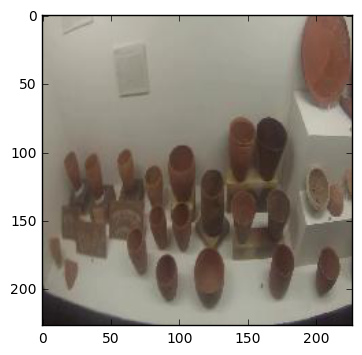

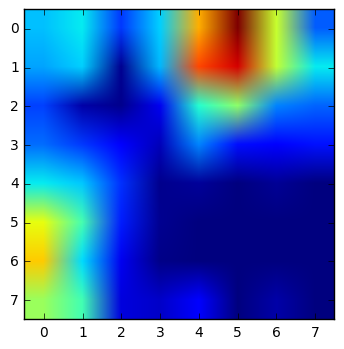

In [99]:
show_outputs(testSetFull[:10], outputs2)

In [100]:
# check if filters are inactive on all images
inputs = torch.Tensor(len(trainSetFull), 3, 227, 227)
for j, (im, lab) in enumerate(trainSetFull):
    inputs[j] = trans(im)
    inputs[j] = norm_image_t(inputs[j])
outputs = model.features(Variable(inputs, volatile=True)).data

mean_response = outputs.mean()

In [101]:
limit = mean_response / 100
print(mean_response, limit)

mean_responses = []
for i in range(n_filters):
    mean_responses.append((i, outputs[:, i, :, :].mean()))

for i, m in sorted(mean_responses, key=lambda x: -x[1]):
    print(i, m)

max_filters = {i: 0 for i in range(n_filters)}
for j, (im, lab) in enumerate(trainSetFull):
    max_i = max(range(n_filters), key=lambda i: outputs[j, i, :, :].norm(1))
    max_filters[max_i] += 1

print(sorted(max_filters.items(), key=lambda x: -x[1]))
for n in range(5):
    print('Filters with at least {0} max responses:{1}'.format(n+1, sum(1 for i in max_filters if max_filters[i] >= n+1)))

(0.4574116508841505, 0.004574116508841505)
(1735, 1.0861033916298284)
(558, 1.0560478712964774)
(1916, 1.0107000046366692)
(550, 0.9526169910351233)
(1740, 0.9313669091398115)
(1404, 0.9136584015438297)
(1364, 0.8957612858120366)
(155, 0.8860234123562281)
(1117, 0.8282310203825651)
(1138, 0.8273739268633782)
(403, 0.8230818755418632)
(166, 0.8073184626733454)
(165, 0.8028338029540574)
(1889, 0.7981704628308619)
(0, 0.7950040310048004)
(1429, 0.7947068242058167)
(1170, 0.7891030527712123)
(1532, 0.7794412279112224)
(781, 0.7792710210957944)
(2, 0.7784563781864593)
(1835, 0.7663544597991017)
(428, 0.7650105544692739)
(1418, 0.7538197828136698)
(618, 0.7532262983078652)
(1219, 0.7530034407660042)
(10, 0.7506321454943111)
(262, 0.7395614375237801)
(1459, 0.7360416232215237)
(1372, 0.7288898673554121)
(1151, 0.7263811300492402)
(250, 0.72549851092745)
(1061, 0.7218432049645734)
(1630, 0.7217353414438428)
(922, 0.7215262731987931)
(1535, 0.7192132405930184)
(174, 0.7187910442083151)
(1904, 0